In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    learning_curve
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

pd.set_option("display.max_columns", None)


In [3]:
df = pd.read_csv("gym_members_exercise_tracking.csv")   # dosya adın buysa
df.head()
df.shape

(973, 15)

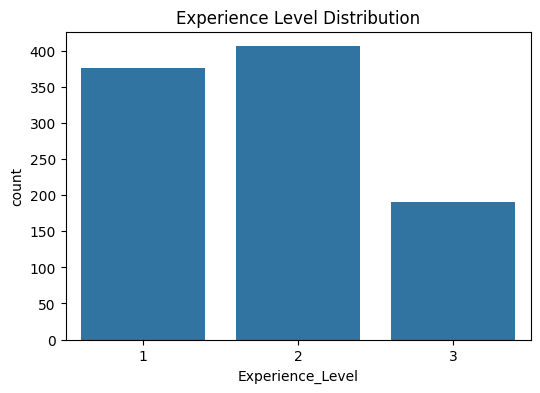

In [4]:
#target distribution
df["Experience_Level"].value_counts()
plt.figure(figsize=(6,4))
sns.countplot(x=df["Experience_Level"])
plt.title("Experience Level Distribution")
plt.show()

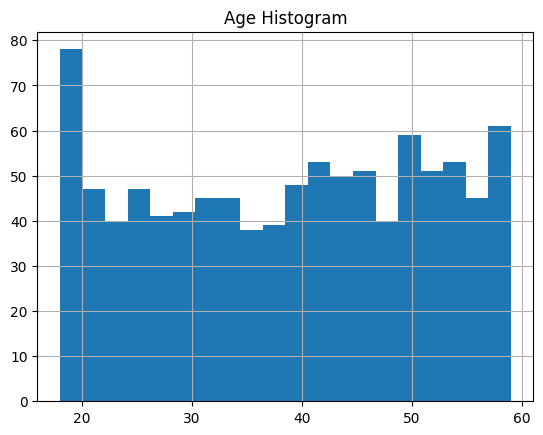

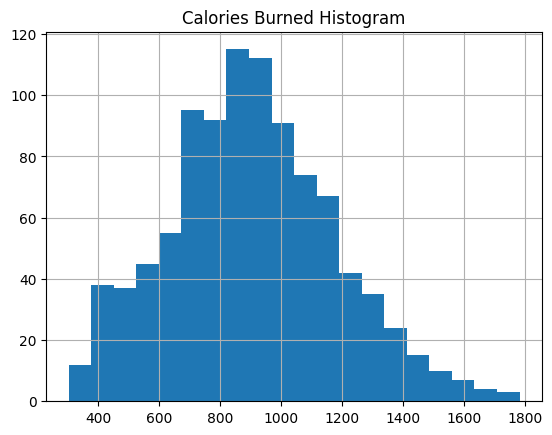

In [5]:
#Histogramlar
df["Age"].hist(bins=20)
plt.title("Age Histogram")
plt.show()
df["Calories_Burned"].hist(bins=20)
plt.title("Calories Burned Histogram")
plt.show()

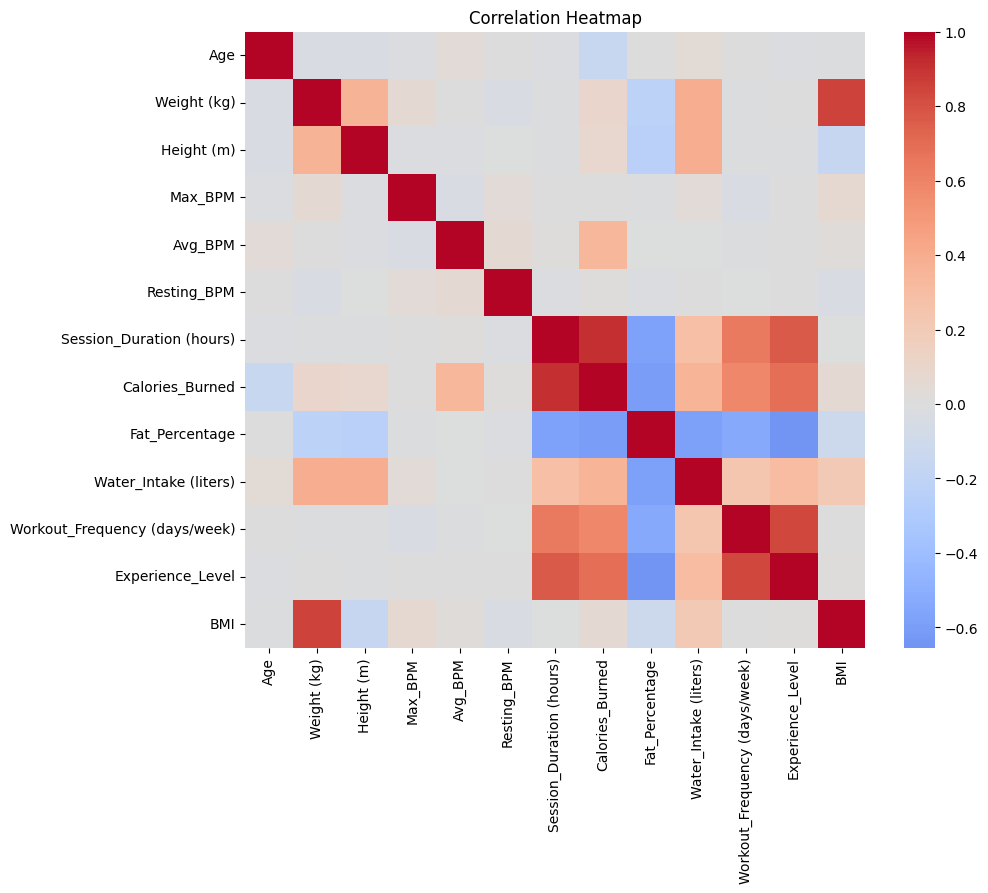

In [6]:
#correelation heatmap
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [7]:
#feature eng
df["Session_Duration_min"] = df["Session_Duration (hours)"] * 60
df["Calories_per_kg"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]


In [8]:
#target - one hot encoding
le = LabelEncoder()
df["Experience_Level"] = le.fit_transform(df["Experience_Level"])
X = df.drop("Experience_Level", axis=1)
y = df["Experience_Level"]
X = pd.get_dummies(X, drop_first=True)

In [9]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [10]:
# Baseline Model
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)

y_pred_base = rf_baseline.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))


Baseline Accuracy: 0.8974358974358975


In [11]:
#GridSearch
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [12]:
#Cross-Validation
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5
)

print("CV Accuracy Mean:", cv_scores.mean())


CV Accuracy Mean: 0.8933167907361454


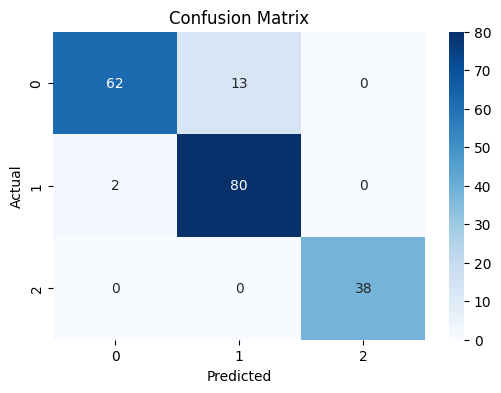

              precision    recall  f1-score   support

           0       0.97      0.83      0.89        75
           1       0.86      0.98      0.91        82
           2       1.00      1.00      1.00        38

    accuracy                           0.92       195
   macro avg       0.94      0.93      0.94       195
weighted avg       0.93      0.92      0.92       195



In [13]:
#Confusion Matrix
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


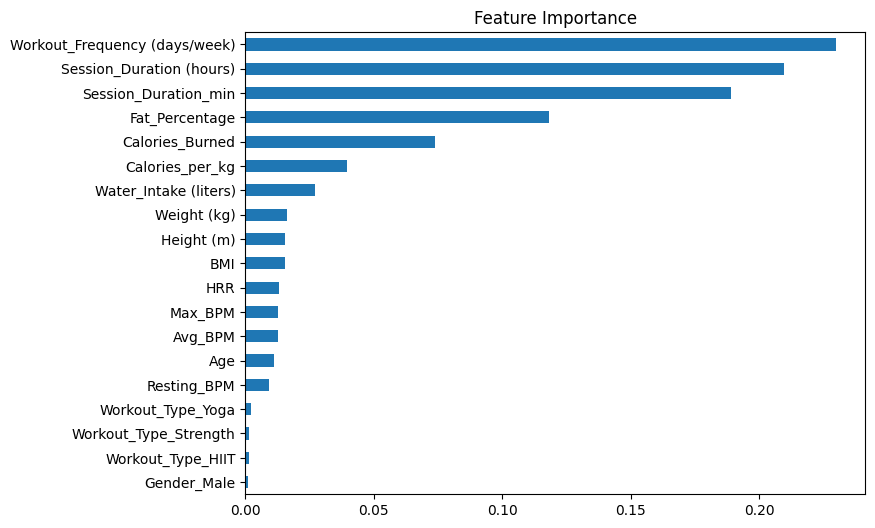

In [14]:
#Feature Importance
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns)

feat_imp.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance")
plt.show()


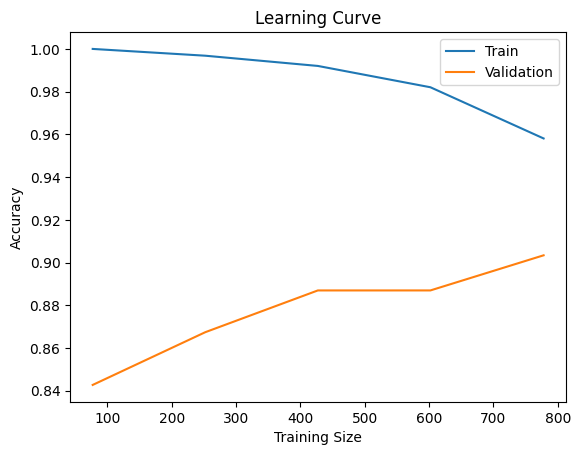

In [15]:
#Learning Curve Cell
X_full = pd.get_dummies(
    df.drop("Experience_Level", axis=1),
    drop_first=True
)
y_full = df["Experience_Level"]

train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_full,
    y_full,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation")
plt.legend()
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


## Final Conclusions

- Random Forest modeli Experience_Level sınıflandırmasında başarılı performans göstermiştir.
- Feature engineering adımları model doğruluğunu artırmıştır.
- Baseline modele kıyasla tuned model daha yüksek doğruluk sağlamıştır.
- Feature importance analizine göre kalp atımı ve kalori temelli değişkenler en etkili faktörlerdir.
- Learning curve, modelin genelleme kabiliyetinin yeterli olduğunu ve ciddi overfitting olmadığını göstermektedir.
